# Centrality Measures with cuGraph and US Patent Citations.
This notebook will demonstrate RAPIDS cuGraph to do centrality calculations on US Patent data

# Downloading the data

Citation: U.S. Patent and Trademark Office. “Data Download Tables.” PatentsView. Accessed [10/06/2024]. https://patentsview.org/download/data-download-tables.

 Both files are used under the Creative Commons license https://creativecommons.org/licenses/by/4.0/


The first file, g_patent.tsv.zip, contains summary data for each patent such as id, title and the location of the original patent document. The table description is available on the [PatentsView site](https://patentsview.org/download/data-download-dictionary).

The second file, g_us_patent_citation.tsv.zip, contains a record for every citation between USPatents. The description of this table is also available on the [PatentsView site](https://patentsview.org/download/data-download-dictionary).

Removing the comment character "#" and running the below lines will download and expand the data into the directory the notebook expects it to be in.

In [1]:
#!wget https://s3.amazonaws.com/data.patentsview.org/download/g_patent.tsv.zip
#!unzip ./g_patent.tsv.zip
#!wget https://s3.amazonaws.com/data.patentsview.org/download/g_us_patent_citation.tsv.zip
#!unzip ./g_us_patent_citation.tsv.zip

In [2]:
# We will create the dataframes using cudf and create the graphs with cuGraph
import cudf
import cugraph

This method takes a list of patents and goes out one hop. It returns the new list of all the patents which can
be used to in the same function to go out an additional hop.

In [3]:
def next_hop(seeds):
    seed_df = seeds.to_frame('seed')
    source_df = citation_df.merge(seed_df, left_on='source', right_on='seed', how='inner')
    target_df = (citation_df.merge(seed_df, left_on='target', right_on='seed', how='inner'))
    links_df = cudf.concat([source_df,target_df])
    links_df = links_df.drop('seed', axis=1)
    new_seed_set = links_df.melt()
    new_seed_set = new_seed_set.drop('variable',axis=1)
    new_seed_set = new_seed_set['value'].drop_duplicates()
    return links_df.drop_duplicates(), new_seed_set

This function displays the top results of all the centrality algorithms

In [4]:
# Print function
def print_centrality(k, dc, bc, kr, pr, ev):

    dc_top = dc.sort_values(by='degree_centrality', ascending=False).head(k).to_pandas()
    bc_top = bc.sort_values(by='betweenness_centrality', ascending=False).head(k).to_pandas()
    kr_top = kr.sort_values(by='katz_centrality', ascending=False).head(k).to_pandas()
    pr_top = pr.sort_values(by='pagerank', ascending=False).head(k).to_pandas()
    ev_top = ev.sort_values(by='eigenvector_centrality', ascending=False).head(k).to_pandas()
    
    df1_styler = dc_top.style.set_table_attributes("style='display:inline'").set_caption('Degree').hide(axis='index')
    df2_styler = bc_top.style.set_table_attributes("style='display:inline'").set_caption('Betweenness').hide(axis='index')
    df3_styler = kr_top.style.set_table_attributes("style='display:inline'").set_caption('Katz').hide(axis='index')
    df4_styler = pr_top.style.set_table_attributes("style='display:inline'").set_caption('PageRank').hide(axis='index')
    df5_styler = ev_top.style.set_table_attributes("style='display:inline'").set_caption('EigenVector').hide(axis='index')

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_()+df4_styler._repr_html_()+df5_styler._repr_html_(), raw=True)

After running the centrality algorithms, this function displays the supplied graph. The dataframe from any of the centrality calculations is also supplied along with the number of the highest ranking nodes we want to emphasize with labels and scale with size based on the centrality value.

In [5]:
def draw_centrality_graph(graph_df, number_to_label, cent_df):
    import networkx as nx
    import matplotlib.pyplot as plt

    top_ones = cent_df.sort_values(by=cent_df.columns[0], ascending=False).head(number_to_label)[cent_df.columns[1]].to_pandas()
    print(top_ones)
    sizes = []
    nodes = []

    plt.rcParams['figure.figsize'] = [12, 8]
    nx_g = nx.from_pandas_edgelist(graph_df.to_pandas())

    for node in nx_g.nodes():
        cent_value =cent_df.loc[cent_df['vertex'] == node, cent_df.columns[0]].values[0]
        nodes.append(node)
        sizes.append((cent_value[0]*3000+10).item())

    pos = nx.spring_layout(nx_g)
    labels = {node: node for node in top_ones}
    nx.draw(nx_g, pos=pos, nodelist=nodes,font_color='red' ,node_size=sizes,node_color='grey', node_shape='o', linewidths=2, labels=labels)

This function executes the five centrality algorithms.

In [6]:
# Compute Centrality
# the centrality calls are very straightforward with the graph being the primary argument
# we are using the default argument values for all centrality functions except where noted.

def compute_centrality(_graph, highest_degree=2000) :

    # Compute Degree Centrality
    _d = cugraph.degree_centrality(_graph)
    print("Degree Centrality done")

    # Compute the Betweenness Centrality
    # The k value is needed in large graphs as by default, it will calculate the
    # betweenness centrality score based on every possible pairs in the graph.
    # Limiting the number of vertices involved in the shortest path search leads to a better runtime.
    # In this case we limit it to 100 samples at most.
    _b = cugraph.betweenness_centrality(_graph,k=100)
    print("Between Centrality done")

    # Compute Katz Centrality
    # alpha is set to one divided by the maximum degree in the graph. This will enable convergence
    # max_iter will determine how many iterations will be run before giving up if convergence doesn't occur
    # tol is the tolerance which determines the maximum difference that indicatates convergence 
    _k = cugraph.katz_centrality(_graph, max_iter=1000, tol=1.0e-2,alpha=1/highest_degree)
    print("Katz Centrality done")

    # Compute PageRank Centrality
    _p = cugraph.pagerank(_graph)
    print("Pagerank done")

    # Compute EigenVector Centrality
    _e = cugraph.eigenvector_centrality(_graph, max_iter=1000, tol=1.0e-3)
    print("Eigenvector Centrality done")

    return _d, _b, _k, _p, _e

Here we load the entire US patent citation edge list into a cuDF dataframe.

In [7]:
# load the citation graph
import cudf
citation_df = cudf.read_csv("../data/g_us_patent_citation.tsv",
                sep='\t',
                header=0,
                usecols=[0,2],
                names=["source", "target"],
                dtype={"source":str,"target":str},
)

In [26]:
# Display the first five edges in the dataframe.
citation_df.head(5)

,source,target
0,10000000,5093563
1,10000000,5751830
2,10000001,7804268
3,10000001,9022767
4,10000001,9090016


The resulting dataframe has over 142 million edges

In [9]:
len(citation_df)

142183260

Choose a patent of interest. In this case we will choose a patent representing an advance in visualizing machine learning models. Adding additional patents to the seed list can be done here.

In [10]:
poi = ["10810491"]

Go out one hop from the patent(s) supplied.

In [11]:
seed_series=cudf.Series(poi)
first_hop_df, first_set = next_hop(seed_series)

Show how many patents cite or are cited by the starting one(s)

In [12]:
len(first_hop_df)

32

In this case we will just use the second hop edge/patent list. However, for demonstation purposes, we show the next_hop function can go out as many hops as necessary to build a relevant graph as needed for different data sets. The code below goes out four levels of separation.

In [13]:
second_hop_df, second_hop_seeds = next_hop(first_set)
third_hop_df, third_hop_seeds = next_hop(second_hop_seeds)
fourth_hop_df, fourth_hop_seeds = next_hop(third_hop_seeds)

These are node (patent) counts at each hop.

In [14]:
len(first_set), len(second_hop_seeds),len(third_hop_seeds),len(fourth_hop_seeds)

(33, 402, 29916, 659475)

These are edge(citation) counts at each hop.

In [15]:
len(first_hop_df), len(second_hop_df),len(third_hop_df),len(fourth_hop_df)

(32, 465, 122774, 5177479)

The contents of the dataframe we will use contains 2 hops.

In [16]:
second_hop_df

,source,target
0,10810491,8234228
1,10810491,6038337
2,11086471,5222210
3,11086471,6049793
4,11086471,7475072
...,...,...
213,RE46310,6038337
214,RE48056,6038337
215,RE47908,6038337
216,RE49334,6038337


Now we will build a directed Graph in cuGraph from the second hop dataframe created above

In [17]:
%%time
G = cugraph.from_cudf_edgelist(second_hop_df,create_using=cugraph.Graph(directed=True),source='source', destination='target')

CPU times: user 92 ms, sys: 24.9 ms, total: 117 ms
Wall time: 114 ms


We use the compute_centrality function above to calculate and note the execution time

In [18]:
%%time
dc, bc, kc, pr, ev = compute_centrality(G)

Degree Centrality done
Between Centrality done
Katz Centrality done
Pagerank done
Eigenvector Centrality done
CPU times: user 115 ms, sys: 24.6 ms, total: 139 ms
Wall time: 137 ms


/home/dacosta/miniforge3/lib/python3.12/site-packages/cugraph/centrality/katz_centrality.py:121: UserWarning: Katz centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/dacosta/miniforge3/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/home/dacosta/miniforge3/lib/python3.12/site-packages/cugraph/centrality/eigenvector_centrality.py:88: UserWarning: Eigenvector centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


We import the formatting package and print out the top 10 patents for each centrality measure

In [19]:
from IPython.display import display_html

print_centrality(10, dc, bc, kc, pr, ev)

degree_centrality,vertex
0.394015,6038337
0.152120,11412041
0.079801,10810491
0.069825,11977958
0.054863,8234228
0.054863,11769180
0.054863,11682052
0.049875,11900046
0.047382,11921730
0.039900,11960575


Now call the function that draws the graph with the specified number of the most central nodes labeled.
The final parameter, pr in this case, for PageRank sends in the particular algorithm results to graph.

306     6038337
7       5450504
284     5408585
355     5497430
307     8234228
21      7398259
320    10810491
308    11182695
312    11304074
256    10379502
257    10432689
339     9743237
Name: vertex, dtype: object


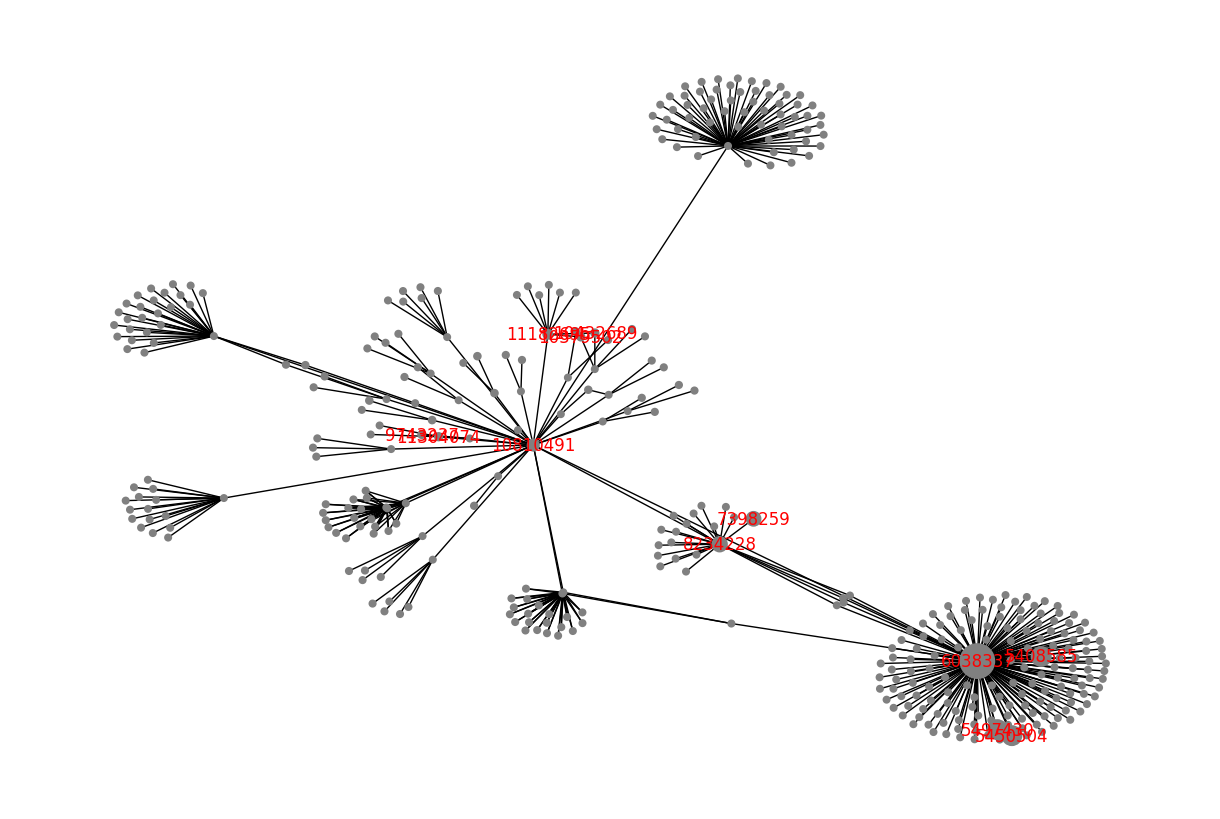

In [20]:
draw_centrality_graph(second_hop_df,12, pr)

Lets run edge betweenness centrality to find the central edges in the graph.

In [21]:
G_2_hops = cugraph.from_cudf_edgelist(second_hop_df,create_using=cugraph.Graph(directed=True),source='source', destination='target')
results=cugraph.edge_betweenness_centrality(G_2_hops).sort_values(ascending=False,by=['betweenness_centrality'])
results.head(10)

,betweenness_centrality,src,dst
194,0.001216,6038337,5408585
195,0.001216,6038337,5450504
196,0.001216,6038337,5497430
207,0.000993,10810491,6038337
208,0.000509,10810491,8234228
38,0.000385,8234228,7398259
307,0.000304,11182695,10810491
291,0.000130,11304074,10810491
203,0.000087,11514361,10810491
301,0.000087,11314969,10810491


Now load the enrichment data. We are only loading the patent_id and title but other columns are available.


In [22]:
title_df = cudf.read_csv("/home/dacosta/data/g_patent.tsv",
                sep='\t',
                header=0,
                usecols=[0,3],
                names=["patent_id", "patent_title"],
                dtype={"patent_id":"str","patent_title":str},
)
len(title_df)


8890049

In [23]:
G_2_hops = cugraph.from_cudf_edgelist(second_hop_df,create_using=cugraph.Graph(directed=True),source='source', destination='target')
results=cugraph.edge_betweenness_centrality(G_2_hops).sort_values(ascending=False,by=['betweenness_centrality'])
results.head(10)

,betweenness_centrality,src,dst
194,0.001216,6038337,5408585
195,0.001216,6038337,5450504
196,0.001216,6038337,5497430
208,0.000993,10810491,6038337
97,0.000509,10810491,8234228
57,0.000385,8234228,7398259
291,0.000304,11182695,10810491
323,0.000130,11304074,10810491
203,0.000087,11514361,10810491
333,0.000087,11314969,10810491


Merge the enrichment data with the highest ranking patent ids found above.

In [24]:
# top number of Patents we are interested in
k=20

dc_top = dc.sort_values(by='degree_centrality', ascending=False).head(k)
bc_top = bc.sort_values(by='betweenness_centrality', ascending=False).head(k)
kr_top = kc.sort_values(by='katz_centrality', ascending=False).head(k)
pr_top = pr.sort_values(by='pagerank', ascending=False).head(k)
ev_top = ev.sort_values(by='eigenvector_centrality', ascending=False).head(k)

df_list = [dc_top, bc_top, kr_top, pr_top, ev_top]
combined = cudf.concat(df_list, axis=0)
combined = cudf.DataFrame(combined['vertex'])
print(combined.columns)
combined = combined.drop_duplicates()
enriched_df = title_df.merge(combined, left_on='patent_id', right_on='vertex', how='inner')
enriched_df = enriched_df.drop('vertex', axis=1 )

Index(['vertex'], dtype='object')


Display the results of the enriched dataframe. We do this in pandas in order to override the default max column width.

In [25]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
enriched_df.to_pandas()

,patent_id,patent_title
0,10074111,Automatically determining a current value for a home
1,10176435,"Method and apparatus for combining techniques of calculus, statistics and data normalization in machine learning for analyzing large volumes of data"
2,10228959,Virtual network for virtual machine communication and migration
3,10318474,Data storage system with heterogenous parallel processors
4,10379502,Control system with machine learning time-series modeling
5,10388274,Confidence checking for speech processing and query answering
6,10402061,Productivity tools for content authoring
7,10432689,Feature generation for online/offline machine learning
8,10460012,Enhanced document services
9,10599924,Semantic page segmentation of vector graphics documents


---
U.S. Patent and Trademark Office. “Data Download Tables.” PatentsView. Accessed [10/06/2024]. https://patentsview.org/ download/data-download-tables.

Data used is Licensed under Creative Commons 4.0 
https://creativecommons.org/licenses/by/4.0/

___
Copyright (c) 2024, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License");  you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
___